In [1]:
import pandas as pd
import numpy as np
import joblib
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn.decomposition import IncrementalPCA
from scipy import sparse
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import graphviz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load datasets
n_samples = 1125678
embedding_dim = 768
sarcasm_feats = pd.read_csv("/content/drive/My Drive/cs3244/features/sarcasm_features.csv")
word_vectorizer = joblib.load("/content/drive/My Drive/cs3244/features/word_vectorizer.pkl")
char_vectorizer = joblib.load("/content/drive/My Drive/cs3244/features/char_vectorizer.pkl")
embeddings = np.memmap("/content/drive/My Drive/cs3244/features/embeddings_memmap.npy",dtype='float32',mode='r',shape=(n_samples, embedding_dim))

In [4]:
sarcasm_feats['text'] = sarcasm_feats['text'].fillna('')
#Transform text using pre-fitted TF-IDF vectorizers
X_word = word_vectorizer.transform(sarcasm_feats['text'])
X_char = char_vectorizer.transform(sarcasm_feats['text'])

In [5]:
# transform embeddings so collab don't crash :(
pca_components = 100    # reduce to 100 dimensions
batch_size_pca = 1024   # batch size for incremental PCA

ipca = IncrementalPCA(n_components=pca_components, batch_size=batch_size_pca)

for start in range(0, n_samples, batch_size_pca):
    end = min(start + batch_size_pca, n_samples)
    ipca.partial_fit(embeddings[start:end])

embeddings_pca = np.zeros((n_samples, pca_components), dtype=np.float32)
for start in range(0, n_samples, batch_size_pca):
    end = min(start + batch_size_pca, n_samples)
    embeddings_pca[start:end] = ipca.transform(embeddings[start:end])

In [6]:
X_sarcasm = sarcasm_feats.drop(columns=['label','text']).select_dtypes(include=np.number).values
# scale numeric features for sacarsm features
scaler = StandardScaler()
X_sarcasm_scaled = scaler.fit_transform(X_sarcasm)

X_sarcasm_sparse = sparse.csr_matrix(X_sarcasm_scaled)
X_emb_pca_sparse = sparse.csr_matrix(embeddings_pca)

# combine features with TF-IDF
X = sparse.hstack([X_emb_pca_sparse, X_word, X_char, X_sarcasm_sparse]).tocsr()
y = sarcasm_feats['label'].values

In [7]:
# train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
sample_frac = 0.3
sample_idx = np.random.choice(X_train.shape[0],
                              size=int(X_train.shape[0] * sample_frac),
                              replace=False)

X_train_sample = X_train[sample_idx]
y_train_sample = y_train[sample_idx]

In [9]:
# Random Forest (balanced) model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    n_jobs=-1,
    random_state=3244,
    verbose=1
)

rf.fit(X_train_sample, y_train_sample)
print("Done training")

# evaluate
y_pred = rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished


Done training


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.2s



Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.84      0.72    112568
           1       0.76      0.48      0.59    112568

    accuracy                           0.66    225136
   macro avg       0.69      0.66      0.65    225136
weighted avg       0.69      0.66      0.65    225136



[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.6s finished


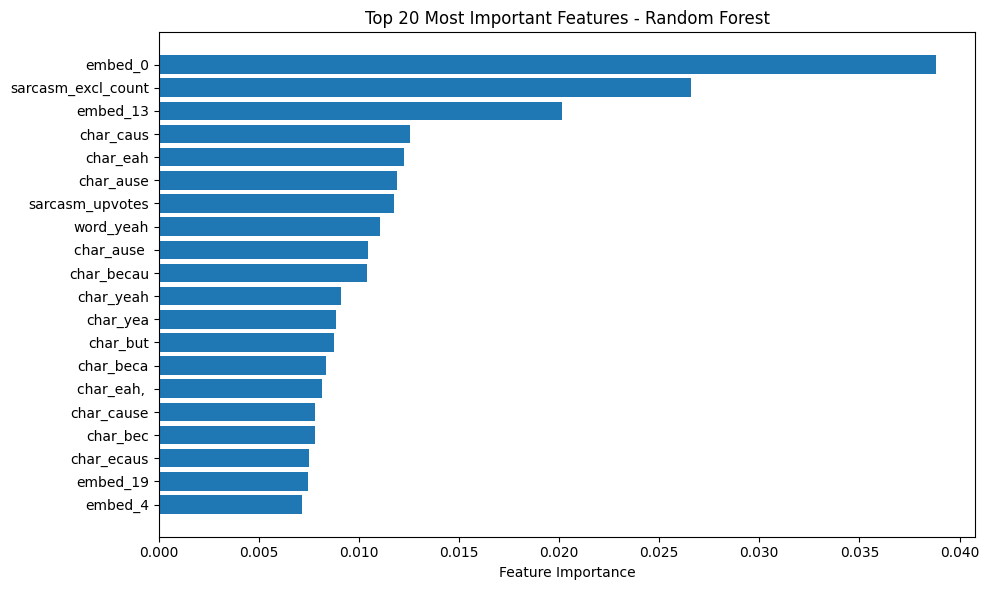

In [10]:
embedding_features_list = [f"embed_{i}" for i in range(X_emb_pca_sparse.shape[1])]
word_features = word_vectorizer.get_feature_names_out()
word_feature_list = [f"word_{w}" for w in word_features]
char_features = char_vectorizer.get_feature_names_out()
char_feature_list = [f"char_{c}" for c in char_features]
handcrafted_features = sarcasm_feats.drop(columns=['label','text']).select_dtypes(include=np.number).columns
handcrafted_feature_list = [f"sarcasm_{f}" for f in handcrafted_features]
all_features = (
    embedding_features_list +
    word_feature_list +
    char_feature_list +
    handcrafted_feature_list
)

importances = rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df.head(20)['feature'][::-1], feat_imp_df.head(20)['importance'][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features - Random Forest")
plt.tight_layout()
plt.show()


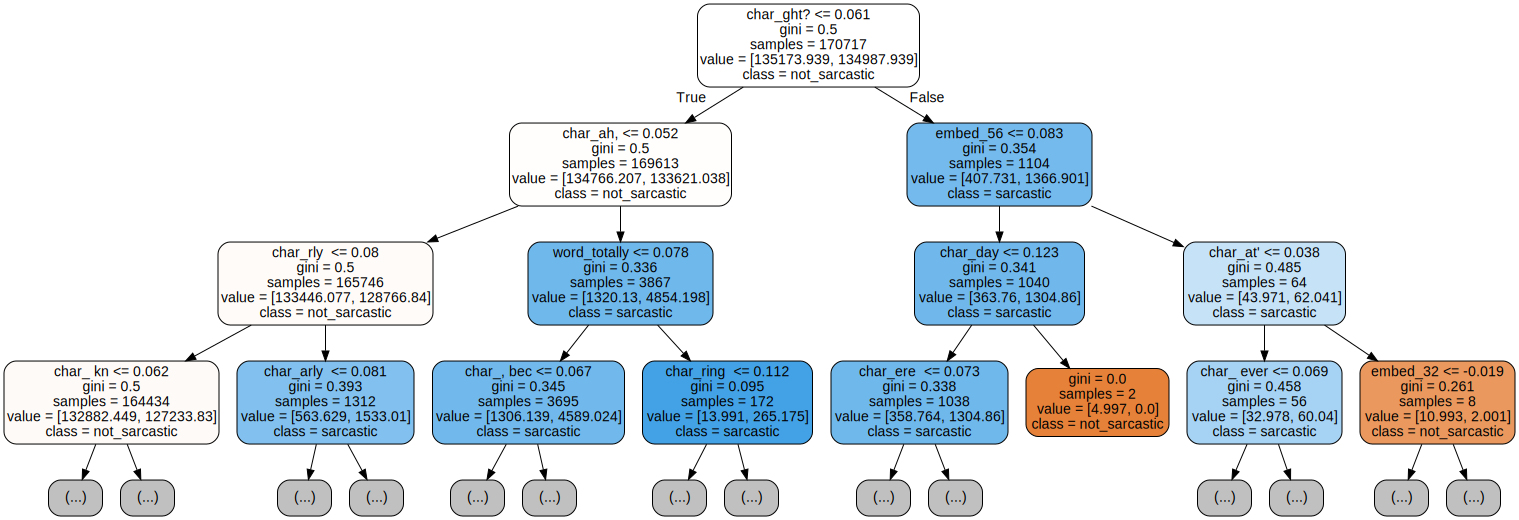

In [11]:
estimator = rf.estimators_[0]
n_features_to_show = estimator.tree_.n_features

feature_names_tree = all_features[:n_features_to_show]

dot_data = export_graphviz(
    estimator,
    out_file=None,
    max_depth=3,  # shallow tree for readability
    feature_names=feature_names_tree,
    class_names=['not_sarcastic', 'sarcastic'],
    rounded=True,
    filled=True
)

graph = graphviz.Source(dot_data)
graph

In [12]:
model_file = "/content/drive/MyDrive/cs3244/models/rf_model.pkl"
joblib.dump(rf, model_file)
print(f"Saved trained model to {model_file}")

Saved trained model to /content/drive/MyDrive/cs3244/models/rf_model.pkl
